In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
import math

In [2]:
output_path = './MH_F_Results_Anvil'

In [3]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

mi = gpd.read_file(os.path.join(output_path, 'MH_F_mi_all.geojson'))
'''
mi = gpd.GeoDataFrame()
for i in range(0, 19):
    if i != 17:
        temp_path = os.path.join(output_path, f'N_{i}', f'MH_F_mi.geojson')
        if os.path.exists(temp_path):
            temp_ = gpd.read_file(temp_path)
            temp_['iter'] = i
            mi = pd.concat([mi, temp_], ignore_index=True)
    else:    
        for ii in range(0, 6):
            temp_path = os.path.join(output_path, f'N_17', f'N_{ii}', f'MH_F_mi.geojson')
            if os.path.exists(temp_path):
                temp_ = gpd.read_file(temp_path)
                temp_['iter'] = i
                mi = pd.concat([mi, temp_], ignore_index=True)

mi.to_file(os.path.join(output_path, 'MH_F_mi_all.geojson'))

'''
mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

mi

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_GROUPQ,dist_GROUPQ,iter,geometry,STATE,Name,Abbr,FIPS,ContiguousUS,Region
0,CO01283S001,38.072333,-103.129028,JOHN MARTIN DAM - FORT LYON LEVEE,1007,dam_study,True,False,True,True,...,0.000000e+00,1000,0,POINT (-103.12903 38.07233),CO,Colorado,CO,8,1,Mountain
1,CA10016,33.891670,-117.925000,BREA DAM,274,dam_study,True,False,True,True,...,4.813142e-02,10000,0,POINT (-117.92500 33.89167),CA,California,CA,6,1,Pacific
2,OH00004S002,40.650549,-81.300936,BOLIVAR DAM - MAGNOLIA LEVEE,243,dam_study,True,False,True,False,...,0.000000e+00,1000,0,POINT (-81.30094 40.65055),OH,Ohio,OH,39,1,EastNorthCentral
3,CA10024,34.113331,-117.968300,SANTA FE DAM,320,dam_study,True,False,True,True,...,4.034530e-09,5000,0,POINT (-117.96830 34.11333),CA,California,CA,6,1,Pacific
4,CA10017,33.914578,-117.840063,CARBON CANYON DAM,309,dam_study,True,False,True,True,...,4.286729e-02,10000,0,POINT (-117.84006 33.91458),CA,California,CA,6,1,Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,OK10318,36.549055,-99.560571,FORT SUPPLY DAM,4203,dam_study,True,False,True,True,...,6.979082e-08,500,18,POINT (-99.56057 36.54905),OK,Oklahoma,OK,40,1,WestSouthCentral
451,MS01494,33.821629,-89.772394,GRENADA DAM,5646,dam_study,True,True,True,True,...,7.755589e-08,500,18,POINT (-89.77239 33.82163),MS,Mississippi,MS,28,1,EastSouthCentral
452,CA10244,37.110662,-119.884580,HIDDEN DAM,5887,dam_study,True,True,True,True,...,3.330669e-16,2500,18,POINT (-119.88458 37.11066),CA,California,CA,6,1,Pacific
453,CA10019,34.260981,-118.386759,HANSEN DAM,1503,dam_study,True,False,True,True,...,0.000000e+00,500,18,POINT (-118.38676 34.26098),CA,California,CA,6,1,Pacific


In [4]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_mi

['MI_POV150',
 'MI_UNEMP',
 'MI_HBURD',
 'MI_NOHSDP',
 'MI_UNINSUR',
 'MI_AGE65',
 'MI_AGE17',
 'MI_DISABL',
 'MI_SNGPNT',
 'MI_LIMENG',
 'MI_MINRTY',
 'MI_MUNIT',
 'MI_MOBILE',
 'MI_CROWD',
 'MI_NOVEH',
 'MI_GROUPQ']

## Overall distribution of SVI variables

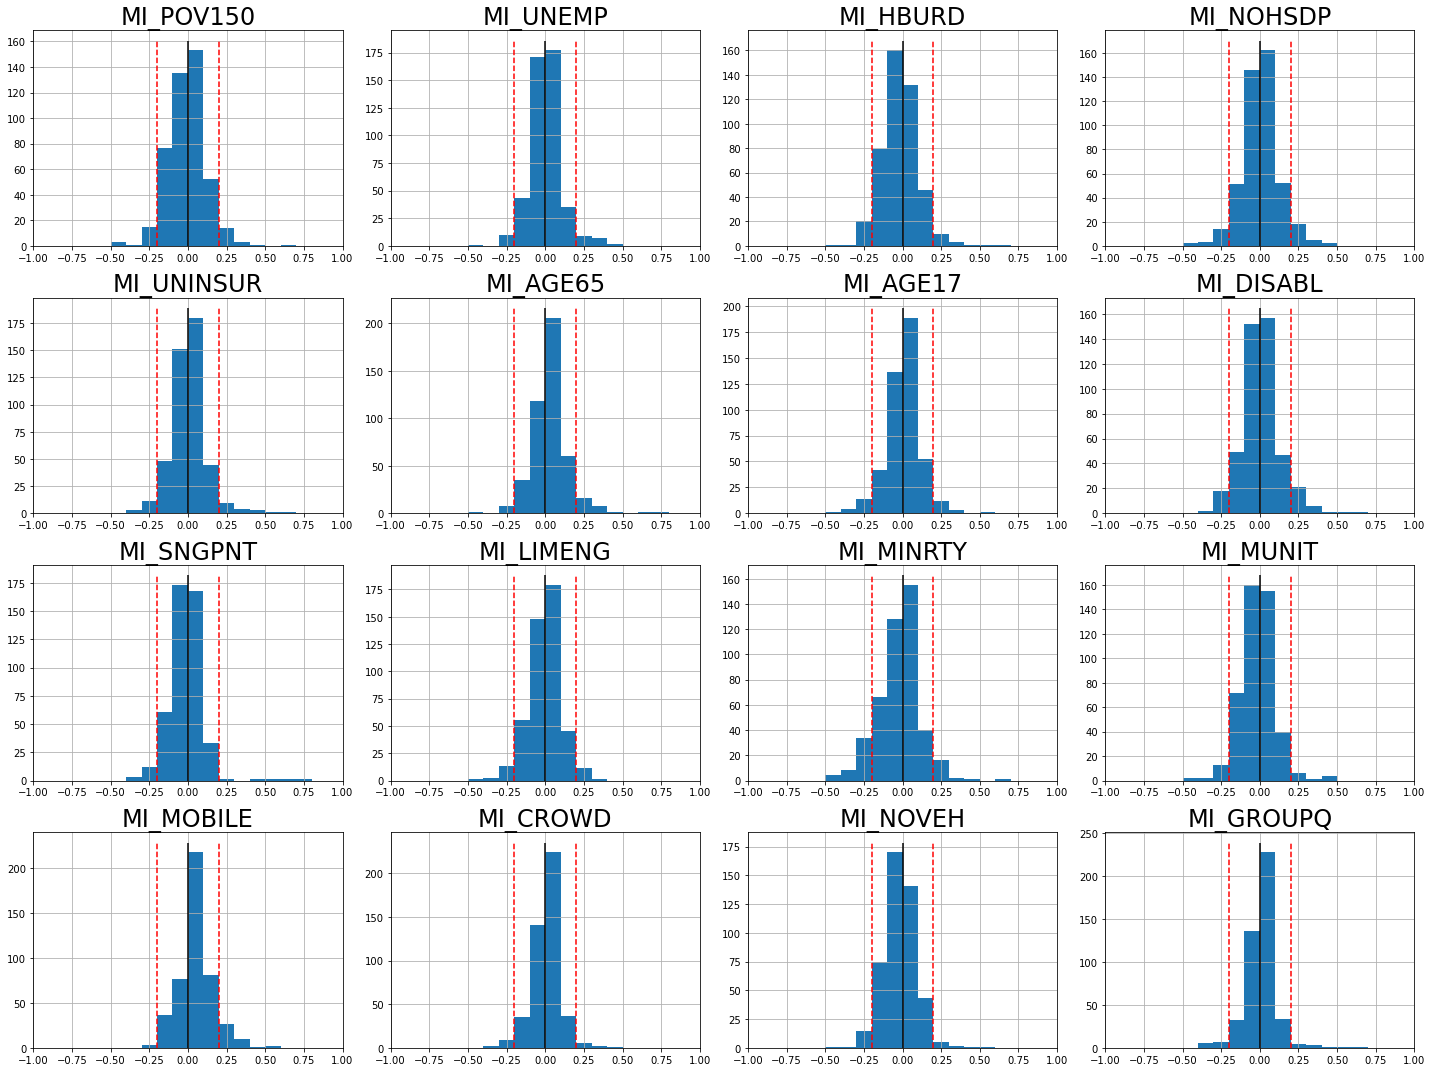

In [5]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]
    
mi_

fig, axes = plt.subplots(4, 4, figsize=(20,15))
ax = axes.reshape(-1)

binwidth = 0.1
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
    mi_[col].hist(ax=ax[idx], bins=bins)
    
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
#     ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(-0.2, 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(0.2, 0, ylim, color='red', linestyle='dashed')
    
    ax[idx].set_title(label=f"{col}", fontsize=24)
    ax[idx].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()
    

## Plot distribution of variables per region

EastSouthCentral 42


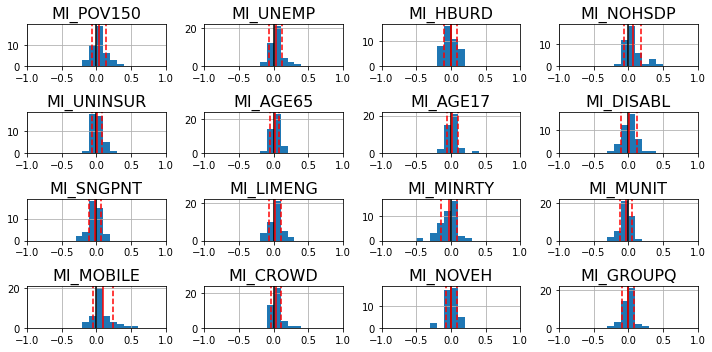

Pacific 58


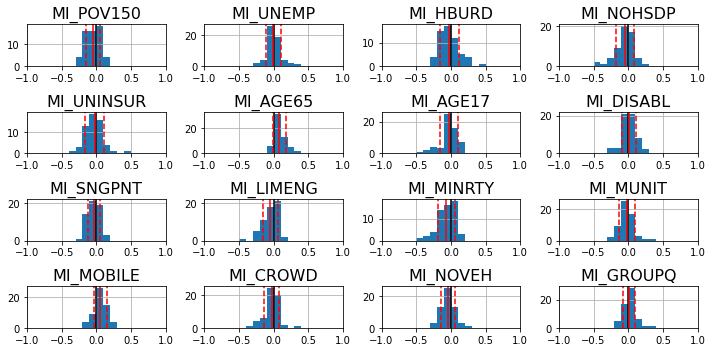

Mountain 26


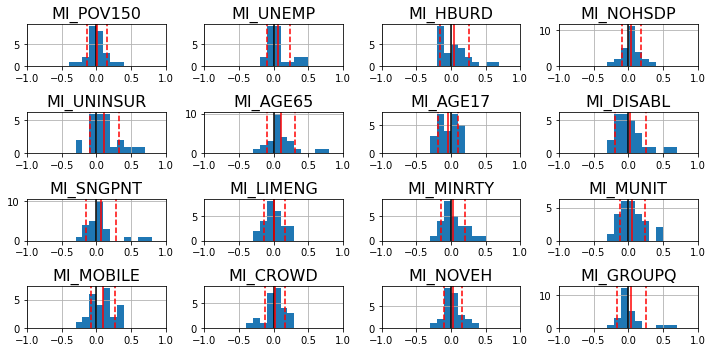

WestSouthCentral 80


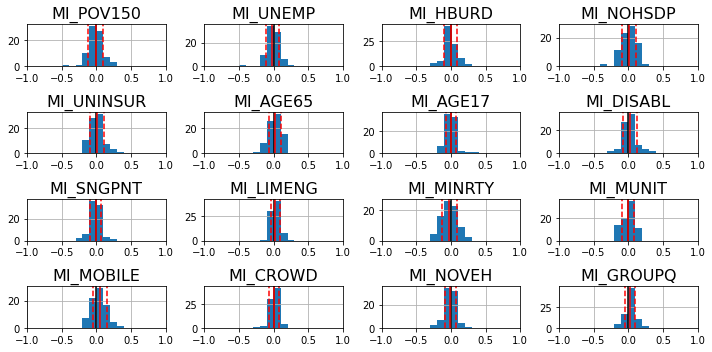

NewEngland 45


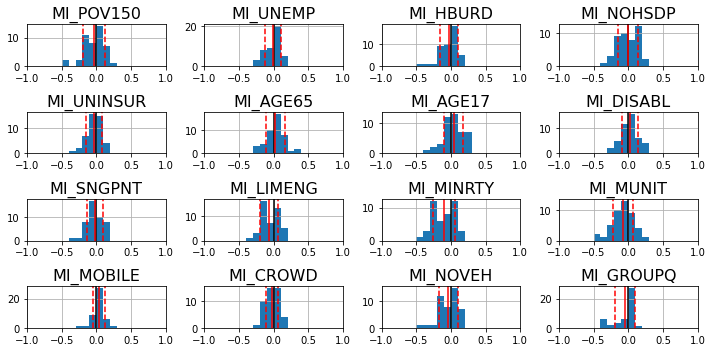

SouthAtlantic 41


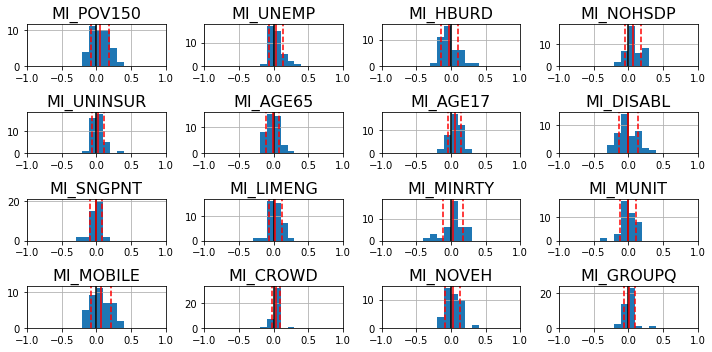

EastNorthCentral 60


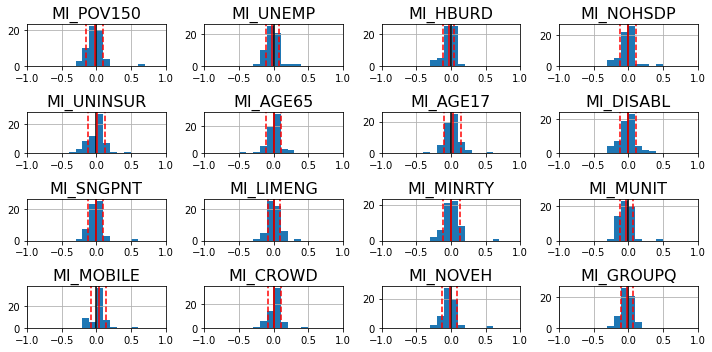

WestNorthCentral 72


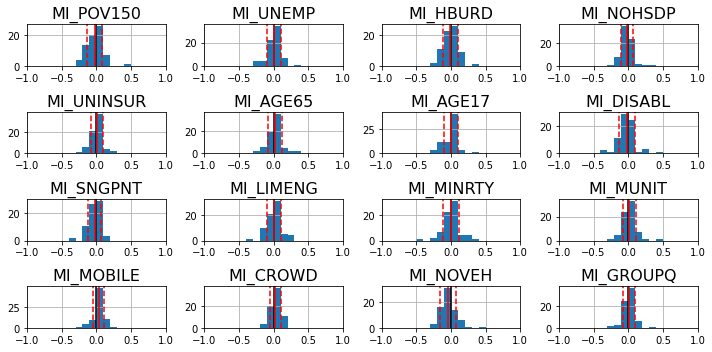

MiddleAtlantic 31


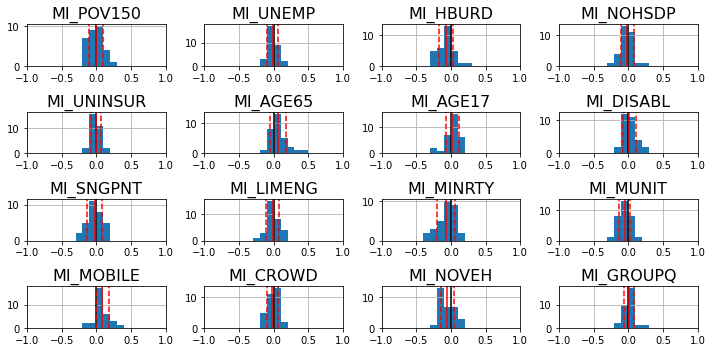

In [6]:
for region in state_lookup['Region'].unique():

    if type(region) == str:
        mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
        print(region, mi_.shape[0])
        
        fig, axes = plt.subplots(4, 4, figsize=(10,5))
        ax = axes.reshape(-1)

        binwidth = 0.1
        n = 10
        for idx, col in enumerate(plot_cols_mi):
            bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
            mi_[col].hist(ax=ax[idx], bins=bins)
            
#             mi_[col].hist(ax=ax[idx], bins=np.arange(min(mi_[col]), max(mi_[col]) + binwidth, binwidth))
            ylim = ax[idx].get_ylim()[1]
            ax[idx].vlines(0, 0, ylim, color='black')
            ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
            ax[idx].vlines(mi_[col].mean() - mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            ax[idx].vlines(mi_[col].mean() + mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            
            ax[idx].set_title(label=f"{col}", fontsize=16)
            ax[idx].set_xlim(-1, 1)
            ax[idx].set_ylim(0, ylim)

        plt.tight_layout()
        plt.show()


## Overall K-Means

In [7]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

#     print(max(km_silhouette, key=km_silhouette.get))
#     print(km_silhouette)
        
    return km_silhouette

def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df

183.0
266.0
6.0


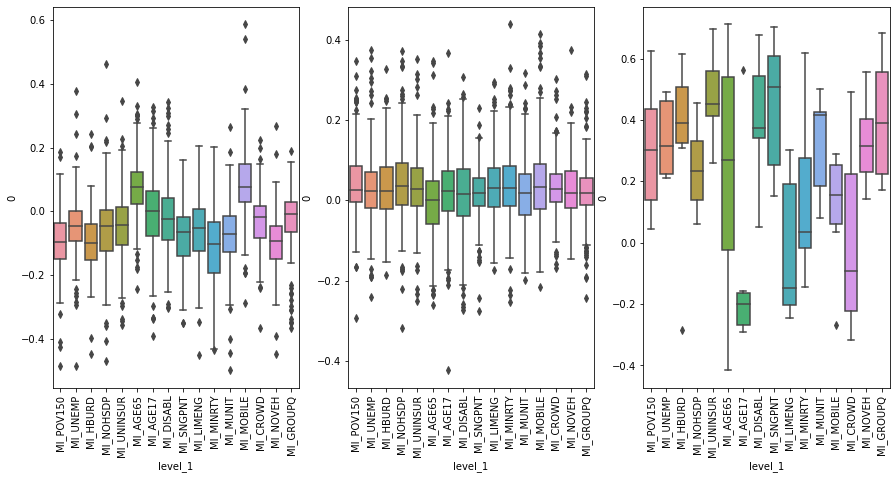

In [8]:
opt_cluster = 3

mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

cluster_mi = kmeans_cluster(mi_, opt_cluster)
cluster_mi

fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))
        
for c in range(opt_cluster):
    temp_cluster = mi_.loc[cluster_mi['cluster'] == c].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
#     ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

In [9]:
# for region in state_lookup['Region'].unique():

#     if type(region) == str:
#         print(region)
#         mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
#         sil_coef = determine_number_of_cluster(mi_)
#         print(f"{region} | optimal cluster count: {max(sil_coef, key=sil_coef.get)}")
        
# #         opt_cluster = max(sil_coef, key=sil_coef.get)
        
#         cluster_mi = kmeans_cluster(mi_, 3)
        
#         fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))
        
#         for c in range(opt_cluster):
#             temp_cluster = mi_.loc[cluster_mi['cluster'] == c].stack().reset_index()
#             print(c, temp_cluster.shape[0]/16)
#             sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
#             ax[c].set_ylim(-0.5, 0.5)
#             ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

#         plt.tight_layout()
#         plt.show()

## Geographical locations 

In [10]:
state = gpd.read_file('./census_geometry/tl_2022_us_state.shp')
state = state.merge(state_lookup, left_on='STUSPS', right_on='Abbr')
state = state.loc[state['ContiguousUS'] == 1]
state = state.to_crs(epsg=5070)

In [11]:
cols = [col.split('_')[1] for col in census_info.keys()]
cols

for idx, row in mi.iterrows():
    for col in cols:
        if (row[f"pval_{col}"] < 0.05) & (row[f"MI_{col}"] >= 0.2):
            mi.at[idx, f'Code_{col}'] = 'PO' # Positive correlation
        elif (row[f"pval_{col}"] < 0.05) & (row[f"MI_{col}"] <= -0.2):
            mi.at[idx, f'Code_{col}'] = 'NE' # Negative correlation
        else:
            mi.at[idx, f'Code_{col}'] = 'NO' # No correlation
            

# Count code (PO, NE, NO) per dam
for idx, row in mi.iterrows():
    mi.at[idx, 'Count_NE'] = sum(row == 'NE')
    mi.at[idx, 'Count_PO'] = sum(row == 'PO')
    mi.at[idx, 'Count_NO'] = sum(row == 'NO')

mi = mi.to_crs(epsg=5070)

## Histogram of the number of positive / negative / not significant variables

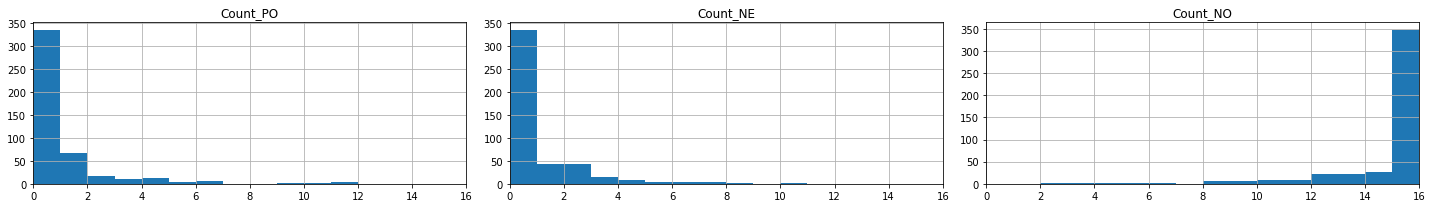

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(20,3))

n=1
binwidth = 1
for idx, col in enumerate(['Count_PO', 'Count_NE', 'Count_NO']):
    bins = np.arange(math.floor(min(mi[col]) * n) / n, 
                     math.ceil(max(mi[col]) * n) / n + binwidth, 
                     binwidth
                    )
    mi.hist(col, ax=ax[idx], bins=bins)
    ax[idx].set_xlim(0, 16)

plt.tight_layout()
plt.show()

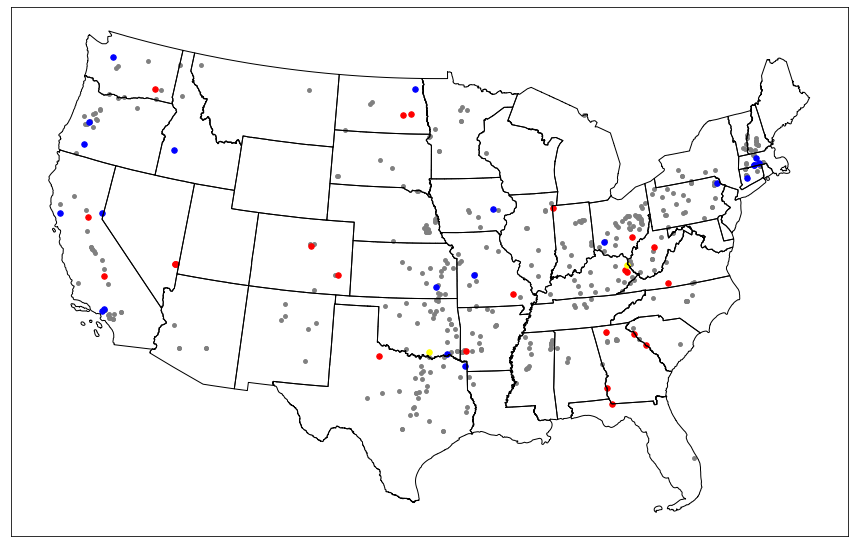

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
state.boundary.plot(ax=ax, color='black', linewidth=1)

mi.loc[(mi['Count_PO'] < 4) & (mi['Count_NE'] < 4)].plot(color='grey', markersize=15, ax=ax)
mi.loc[(mi['Count_PO'] >= 4) & (mi['Count_NE'] < 4)].plot(color='red', markersize=30, ax=ax)
mi.loc[(mi['Count_NE'] >= 4) & (mi['Count_PO'] < 4)].plot(color='blue', markersize=30, ax=ax)
mi.loc[(mi['Count_PO'] >= 4) & (mi['Count_NE'] >= 4)].plot(color='yellow', markersize=30, ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Locations and histograms of dams that shows more than 6 positive Moran's I

In [14]:
import mapclassify

print(mapclassify.NaturalBreaks(mi['Count_PO']))
print(mapclassify.NaturalBreaks(mi['Count_NE']))
print(mapclassify.NaturalBreaks(mi['Count_NO']))

NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.00] |   334
( 0.00,  1.00] |    67
( 1.00,  3.00] |    28
( 3.00,  6.00] |    21
( 6.00, 12.00] |     5
NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.00] |   334
( 0.00,  1.00] |    42
( 1.00,  3.00] |    56
( 3.00,  6.00] |    16
( 6.00, 11.00] |     7
NaturalBreaks         

   Interval      Count
----------------------
[ 2.00,  6.00] |     8
( 6.00, 10.00] |    22
(10.00, 13.00] |    52
(13.00, 15.00] |    86
(15.00, 16.00] |   287


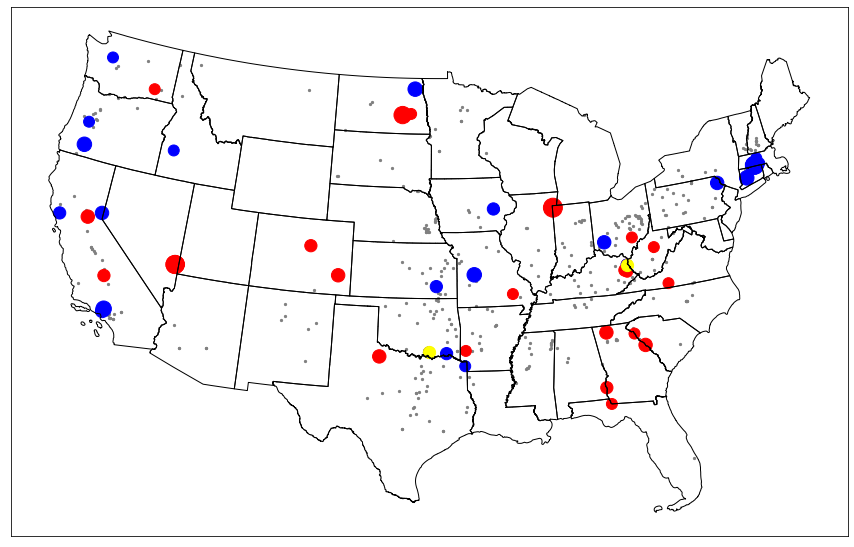

In [15]:
fig, ax = plt.subplots(figsize=(15,15))

state.boundary.plot(ax=ax, color='black', linewidth=1)

mi.plot(markersize=5, color='grey', ax=ax)

mi_po = mi.loc[mi['Count_PO'] >= 4]
mi_po.plot(markersize=mi_po['Count_PO'] * 30, color='red', ax=ax)

mi_ne = mi.loc[mi['Count_NE'] >= 4]
mi_ne.plot(markersize=mi_ne['Count_NE'] * 30, color='blue', ax=ax)

mi_mix = mi.loc[(mi['Count_NE'] >= 4) & (mi['Count_PO'] >= 4)]
mi_mix.plot(markersize=150, color='yellow', ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

23 dams in the category Count_NE


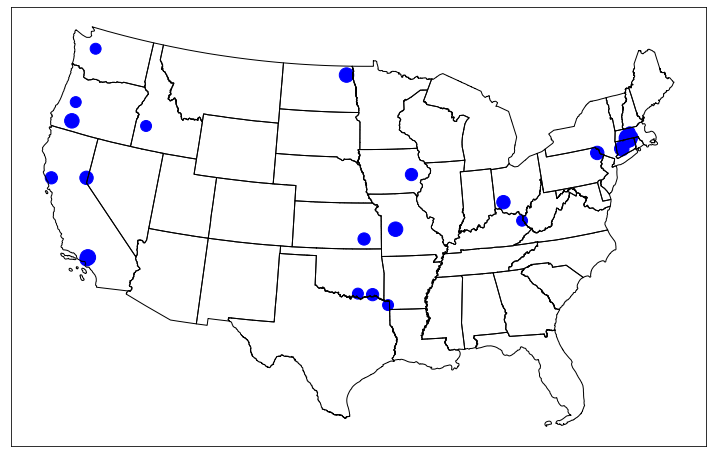

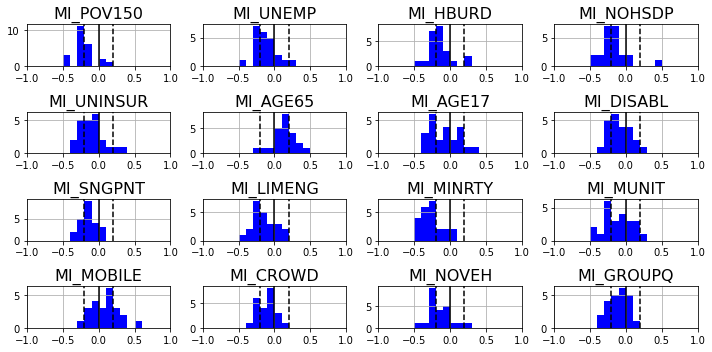

26 dams in the category Count_PO


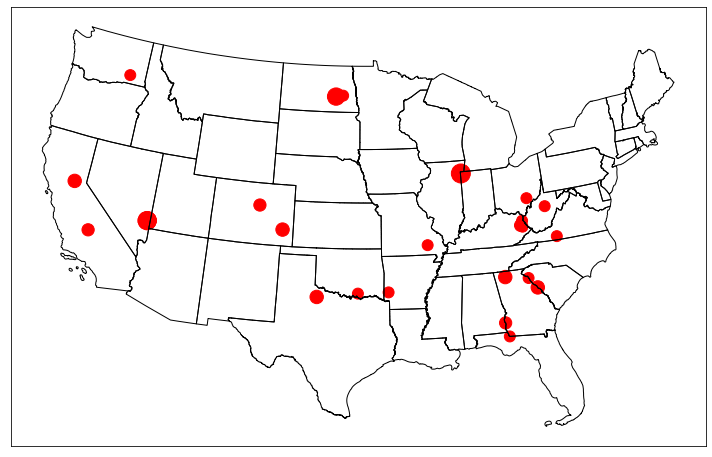

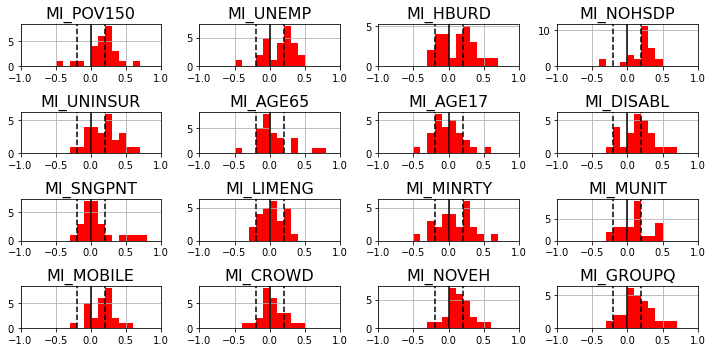

In [16]:
def plot_dams_per_characteristic(mi_gdf, col, plot_cols, state_gdf):
    temp_mi_gdf = mi_gdf.loc[mi_gdf[col] >= 4]
    print(f"{temp_mi_gdf.shape[0]} dams in the category {col}")


    fig, ax = plt.subplots(figsize=(10, 10))

    state_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    if col == 'Count_NE':
        plot_color = 'blue'
    elif col == 'Count_PO':
        plot_color = 'red'
    else:
        plot_color = 'grey'
    
    temp_mi_gdf.plot(markersize=temp_mi_gdf[col] * 30, color=plot_color, ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(4, 4, figsize=(10,5))
    ax = axes.reshape(-1)

    binwidth = 0.1
    n = 10
    for idx, plot_col in enumerate(plot_cols):
        bins = np.arange(math.floor(min(temp_mi_gdf[plot_col]) * n) / n, math.ceil(max(temp_mi_gdf[plot_col]) * n) / n + binwidth, binwidth)
    
        temp_mi_gdf[plot_col].hist(ax=ax[idx], bins=bins, color=plot_color)
        ylim = ax[idx].get_ylim()[1]
        ax[idx].vlines(0, 0, ylim, color='black')
        ax[idx].vlines(-0.2, 0, ylim, color='black', linestyle='dashed')
        ax[idx].vlines(0.2, 0, ylim, color='black', linestyle='dashed')
        ax[idx].set_title(label=f"{plot_col}", fontsize=16)
        ax[idx].set_xlim(-1, 1)
        ax[idx].set_ylim(0, ylim)

    plt.tight_layout()
    plt.show()
    
    
    return temp_mi_gdf


negative_dams = plot_dams_per_characteristic(mi, 'Count_NE', plot_cols_mi, state)
positive_dams = plot_dams_per_characteristic(mi, 'Count_PO', plot_cols_mi, state)

2


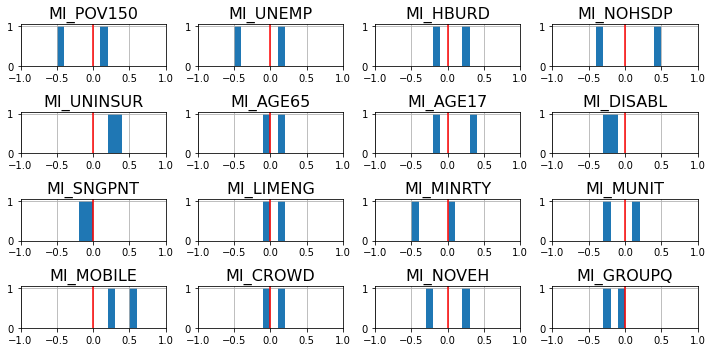

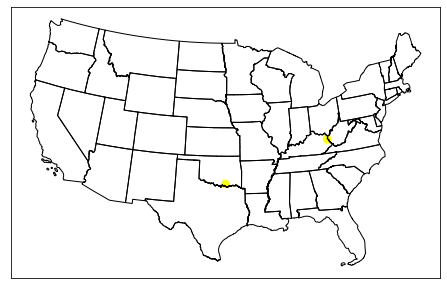

In [17]:
temp_mi = mi.loc[(mi['Count_NE'] >= 4) & (mi['Count_PO'] >= 4)]
print(temp_mi.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(10,5))
ax = axes.reshape(-1)

binwidth = 0.1
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(temp_mi[col]) * n) / n, math.ceil(max(temp_mi[col]) * n) / n + binwidth, binwidth)
    temp_mi[col].hist(ax=ax[idx], bins=bins)
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='red')

    ax[idx].set_title(label=f"{col}", fontsize=16)
    ax[idx].set_xlim(-1, 1)
    ax[idx].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

state.boundary.plot(ax=ax, color='black', linewidth=1)
temp_mi.plot(markersize=temp_mi['Count_NE'] * 15, color='yellow', ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

408


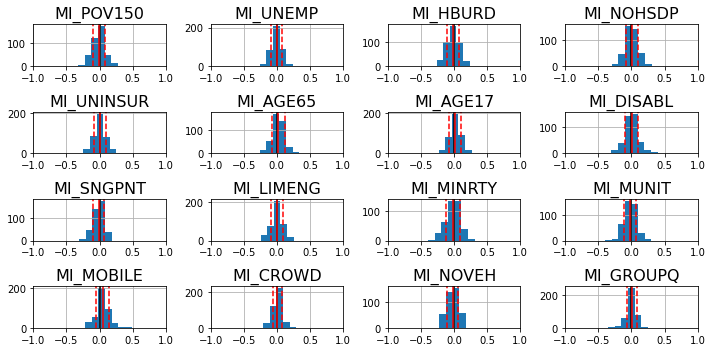

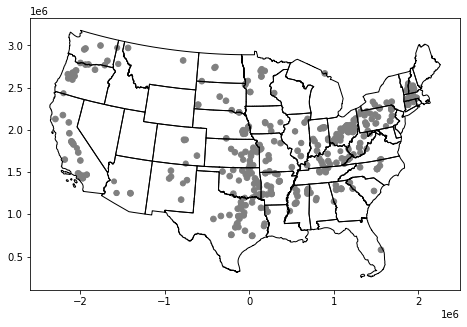

In [18]:
temp_mi = mi.loc[(mi['Count_PO'] < 4) & (mi['Count_NE'] < 4)]
print(temp_mi.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(10,5))
ax = axes.reshape(-1)

binwidth = 0.1
for idx, col in enumerate(plot_cols_mi):
    temp_mi[col].hist(ax=ax[idx], bins=np.arange(min(temp_mi[col]), max(temp_mi[col]) + binwidth, binwidth))
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
    ax[idx].vlines(temp_mi[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(temp_mi[col].mean() - temp_mi[col].std(), 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(temp_mi[col].mean() + temp_mi[col].std(), 0, ylim, color='red', linestyle='dashed')

    ax[idx].set_title(label=f"{col}", fontsize=16)
    ax[idx].set_xlim(-1, 1)
    ax[idx].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

state.boundary.plot(ax=ax, color='black', linewidth=1)
temp_mi.plot(markersize=temp_mi['Count_NO'] * 2, color='grey', ax=ax)
plt.show()

## Correlation between the Moran's I which indicates the correlation between Inundated Area and SVI related variables 

<AxesSubplot:>

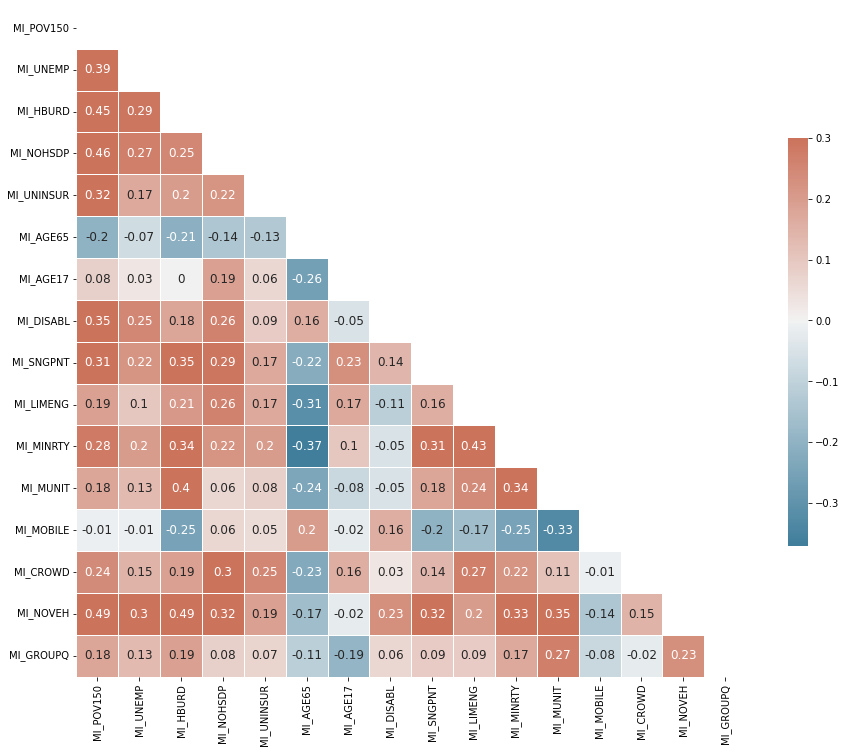

In [19]:
corr = mi[plot_cols_mi].corr('kendall')
corr = corr.round(decimals=2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":12})

In [20]:
import matplotlib.colors as colors

In [21]:
def shiftedColorMap(cmap, start=-0.37, midpoint=0.5, stop=0.49, name='shiftedcmap_'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

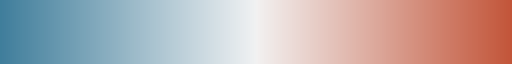

In [22]:
cmap

In [23]:
corr.min().min()

-0.37

In [24]:
max_val = 0
for col in corr.columns:
    temp_max = corr[col].nlargest(2)[1]
    if temp_max > max_val:
        max_val = temp_max
max_val

0.49

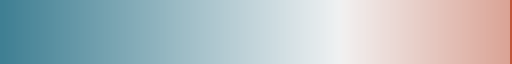

In [25]:
cmap_ = sns.diverging_palette(220, 20, as_cmap=True)

cmap_shifted = shiftedColorMap(cmap_, start=0, midpoint=1, stop=1.5)
cmap_shifted

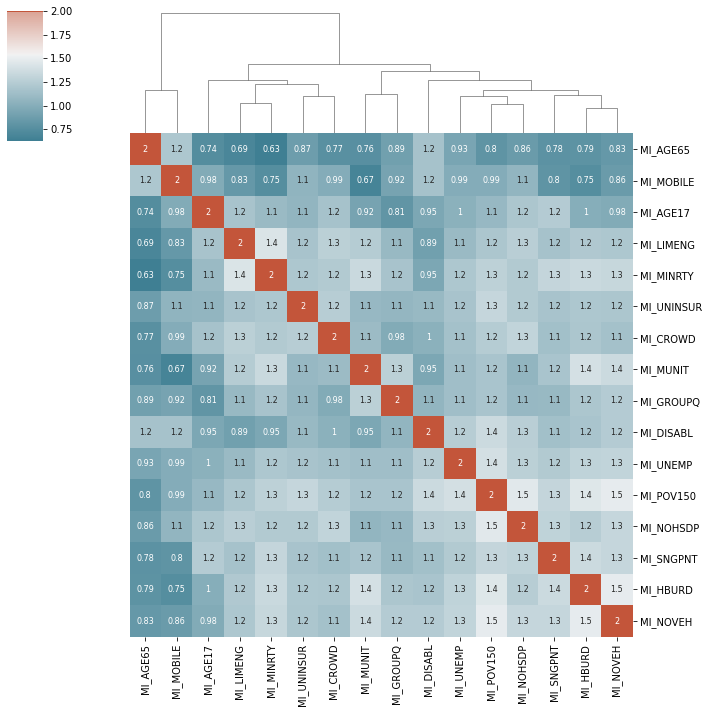

In [26]:
corr = mi[plot_cols_mi].corr('kendall')
corr = corr.round(decimals=2)
corr = corr +1

g = sns.clustermap(corr, method='ward', cmap=cmap_shifted, annot=True, annot_kws={"fontsize":8})

values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
new_values = np.ma.array(values)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_row_dendrogram.set_visible(False)
plt.show()

## Dam locations per variable and per Positive / Negative Moran's I 

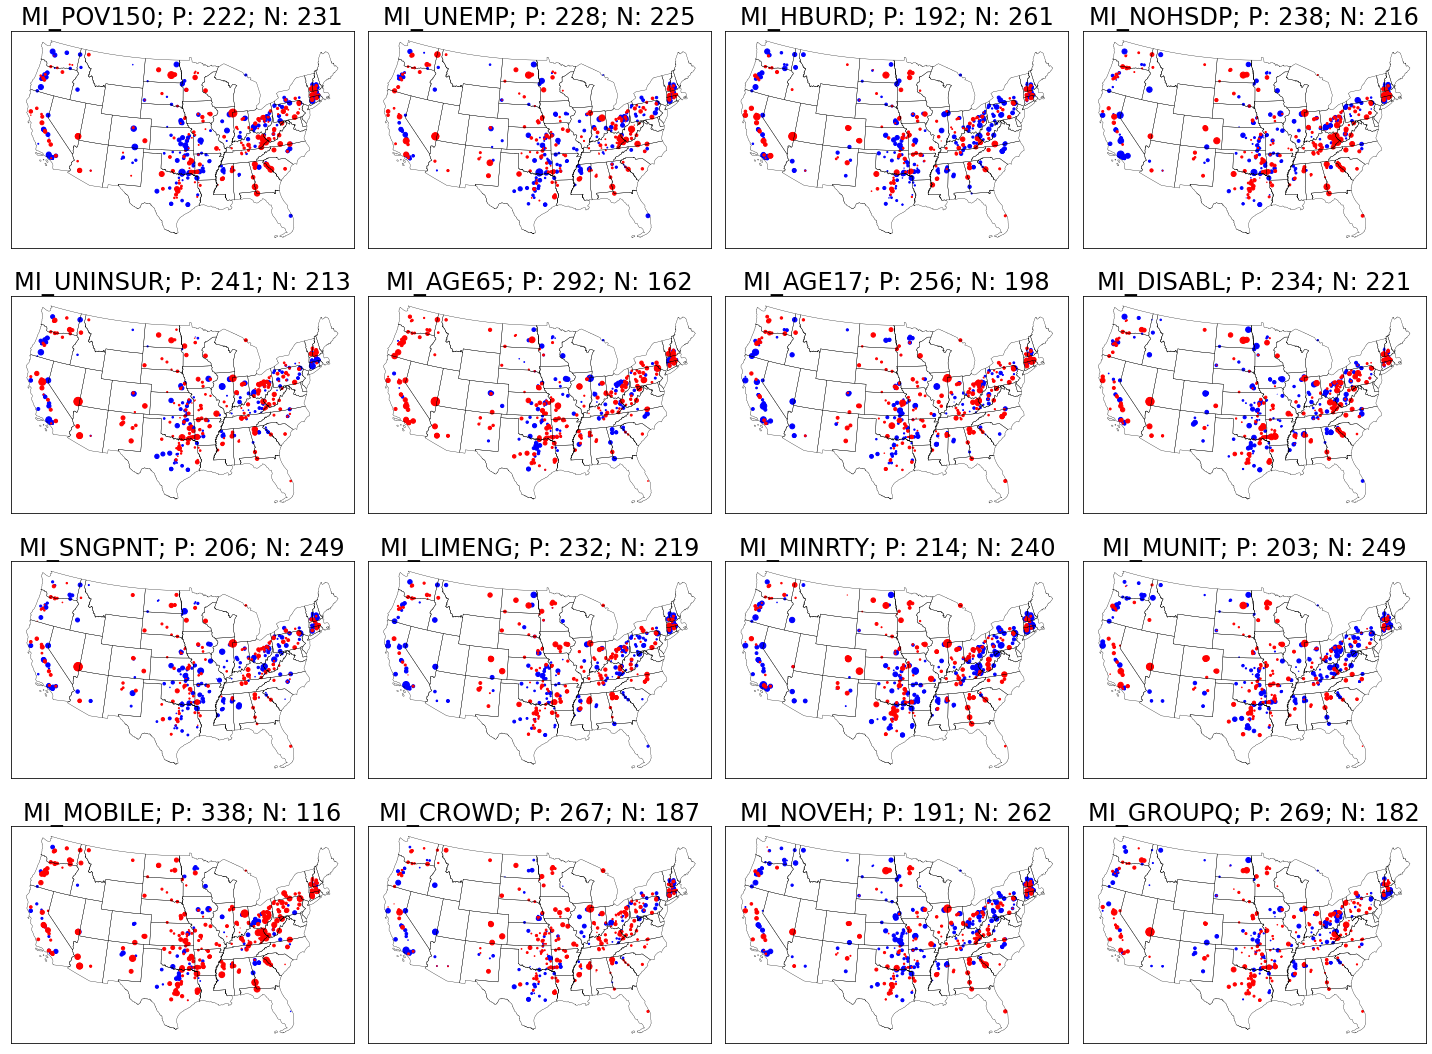

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

ax = axes.reshape(-1)
  
for idx, col in enumerate(plot_cols_mi):
    state.boundary.plot(ax=ax[idx], color='black', linewidth=0.3)
    
    negative_mi = mi.loc[mi[col] < 0]
    negative_mi.plot(markersize=negative_mi[col].abs()*100, color='blue', ax=ax[idx])
    positive_mi = mi.loc[mi[col] > 0]
    positive_mi.plot(markersize=positive_mi[col].abs()*100, color='red', ax=ax[idx])
    
    ax[idx].set_title(label=f"{col}; P: {positive_mi.shape[0]}; N: {negative_mi.shape[0]}", fontsize=24)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()
